In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
from time import time

In [2]:
from citrination_client import CitrinationClient
from saxskit.saxs_models import get_data_from_Citrination
from saxskit.saxs_models import train_classifiers, train_regressors, save_models

In [14]:
from sklearn import preprocessing,linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Training saxskit models using data from Citrination

In [3]:
p = os.getcwd()
d, _  = os.path.split(p)
classifiers_path = os.path.join(d,'saxskit','modeling_data','scalers_and_models.yml')
regressors_path = os.path.join(d,'saxskit','modeling_data','scalers_and_models_regression.yml')

#### Step 1. Get data from Citrination using Citrination credentials

In [4]:
api_key_file = os.path.join(d, 'api_key.txt')
if not os.path.exists(api_key_file):
    print("Citrination api key file did not find")

In [5]:
with open(api_key_file, "r") as g:
    a_key = g.readline().strip()
cl = CitrinationClient(site='https://slac.citrination.com',api_key=a_key)

data = get_data_from_Citrination(client = cl, dataset_id_list= [1,15,16]) # [1,15] is a list of datasets ids

In [6]:
data.head(3)

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,I0_floor,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I_pkcenter,q_pkcenter,pk_hwhm
929,R6,69.9919,2.75363,0.0023155,36.9744,4.43349,0.0815341,0.00185529,0.0951157,-0.105535,...,0,None,None,None,None,None,None,None,None,None
1079,R12,1.70737,1.47014,0.0395189,18.7728,2.07052,0.194813,0.00171821,0.325834,0.268356,...,0,None,None,None,None,None,None,None,None,None
1688,Reaction_C,6.97652,1.01068,0.00146365,5.45112,2.55398,0.0997364,0.00238663,0.0955607,0.111898,...,0.029541,None,None,None,760.157,17.2006,0.0885825,None,None,None


In [12]:
data.columns

Index(['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq', 'I0_over_Imean', 'I0_curvature',
       'q_at_half_I0', 'q_at_Iq4_min1', 'pIq4_qwidth', 'pI_qvertex',
       'pI_qwidth', 'unidentified', 'guinier_porod', 'spherical_normal',
       'diffraction_peaks', 'I0_floor', 'G_gp', 'rg_gp', 'D_gp', 'I0_sphere',
       'r0_sphere', 'sigma_sphere', 'I_pkcenter', 'q_pkcenter', 'pk_hwhm'],
      dtype='object')

In [7]:
t0 = time()
scalers, models, accuracy = train_classifiers(data, hyper_parameters_search = True, model='all')
print("Training took about {:.2f} minutes".format((time()-t0)/60))

save_models(scalers, models, accuracy, classifiers_path)

Training took about 4.43 minutes


In [8]:
print('-----trained model accuracies-----')
for model_name, acc in accuracy.items():
    print('{}: {:.4f}'.format(model_name,acc))

-----trained model accuracies-----
unidentified: 0.9888
spherical_normal: 0.9870
guinier_porod: 0.8213
diffraction_peaks: 0.9800


In [9]:
experiments = data.experiment_id.unique()
experiments

array(['R6', 'R12', 'Reaction_C', 'R2', 'R3', 'R1', 'R5', 'R4',
       'Reaction_D', 'Reaction_G', 'Reaction_B', 'Reaction_A', 'R13',
       'Reaction_H', 'R7', 'Reaction_E'], dtype=object)

In [10]:
features = ['Imax_over_Imean',
        'Imax_sharpness',
        'I_fluctuation',
        'logI_fluctuation',
        'logI_max_over_std',
        'r_fftIcentroid',
        'r_fftImax',
        'q_Icentroid',
        'q_logIcentroid',
        'pearson_q',
        'pearson_q2',
        'pearson_expq',
        'pearson_invexpq']

In [11]:
def set_param(m_s, param):
    for k, v in param.items():
        if isinstance(v, list):
            setattr(m_s, k, np.array(v))
        else:
            setattr(m_s, k, v)

In [15]:
test_results = [] # dataframes
unidentified_scores = []
spherical_normal_scores = []
guinier_porod_scores = []
diffraction_peaks_scores = []

for d in experiments:
    train = data[data['experiment_id']!= d]
    test = data[data['experiment_id']== d]
    scalers, models, accuracy = train_classifiers(train, hyper_parameters_search = True, model='all')
    
    s1 = preprocessing.StandardScaler()
    set_param(s1,scalers['unidentified'])
    transf1 = s1.transform(test[features])
    m1 = linear_model.SGDClassifier()
    set_param(m1,models['unidentified'])
    test.unidentified_predicted = m1.predict(transf1)
    test_score_unidentified = m1.score(transf1, test['unidentified'])
    unidentified_scores.append(test_score_unidentified)
    
    s2 = preprocessing.StandardScaler()
    set_param(s2,scalers['spherical_normal'])
    transf2 = s2.transform(test[features])
    m2 = linear_model.SGDClassifier()
    set_param(m2,models['spherical_normal'])
    test.spherical_normal_predicted = m2.predict(transf2)
    test_score_spherical_normal = m2.score(transf2, test['spherical_normal'])
    spherical_normal_scores.append(test_score_spherical_normal)
    
    s3 = preprocessing.StandardScaler()
    set_param(s3,scalers['guinier_porod'])
    transf3 = s3.transform(test[features])
    m3 = linear_model.SGDClassifier()
    set_param(m3,models['guinier_porod'])
    test.guinier_porod = m3.predict(transf1)
    test_score_guinier_porod = m3.score(transf3, test['guinier_porod'])
    guinier_porod_scores.append(test_score_guinier_porod)
    
    s4 = preprocessing.StandardScaler()
    set_param(s4,scalers['diffraction_peaks'])
    transf4 = s4.transform(test[features])
    m4 = linear_model.SGDClassifier()
    set_param(m4,models['diffraction_peaks'])
    test.diffraction_peaks_predicted = m4.predict(transf4)
    test_score_diffraction_peaks = m4.score(transf4, test['diffraction_peaks'])
    diffraction_peaks_scores.append(test_score_diffraction_peaks)
    
    test_results.append(test)

Text(0,0.9,'Number of outcomes')

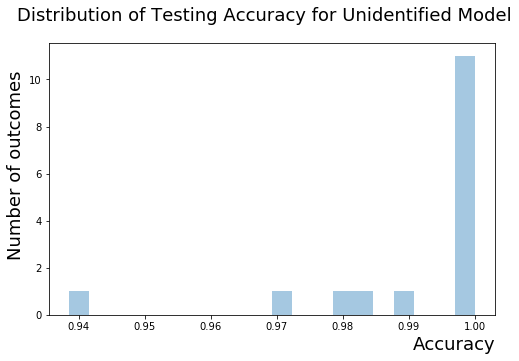

In [16]:
plt.figure(figsize=(8,5))
sns.distplot(unidentified_scores, kde=False, bins=20)
plt.suptitle("Distribution of Testing Accuracy for Unidentified Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

Text(0,0.9,'Number of outcomes')

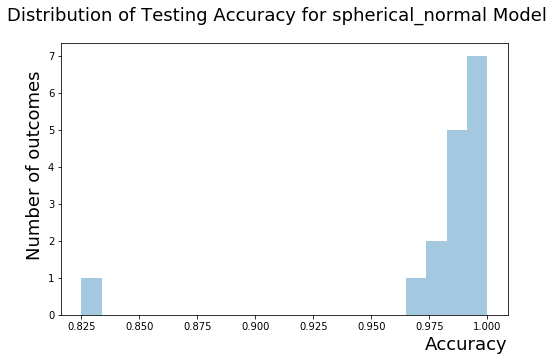

In [17]:
plt.figure(figsize=(8,5))
sns.distplot(spherical_normal_scores, kde=False, bins=20)
plt.suptitle("Distribution of Testing Accuracy for spherical_normal Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

Text(0,0.9,'Number of outcomes')

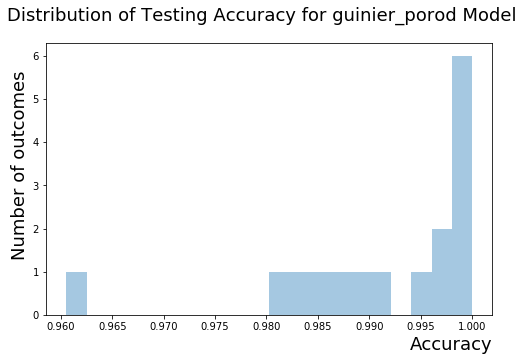

In [18]:
plt.figure(figsize=(8,5))
sns.distplot(guinier_porod_scores, kde=False, bins=20)
plt.suptitle("Distribution of Testing Accuracy for guinier_porod Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

Text(0,0.9,'Number of outcomes')

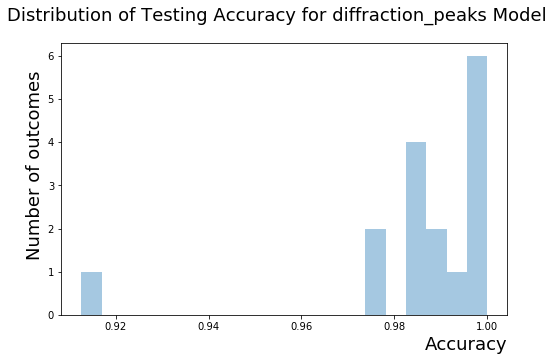

In [19]:
plt.figure(figsize=(8,5))
sns.distplot(diffraction_peaks_scores, kde=False, bins=20)
plt.suptitle("Distribution of Testing Accuracy for diffraction_peaks Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [21]:
train_good = data[data['unidentified']==False]

In [22]:
parameters = {'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1], #regularisation coef, default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.85, 1.0]} #using with elasticnet only; default 0.15

In [26]:
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GridSearchCV

cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['guinier_porod']], groups=train_good['experiment_id'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['guinier_porod'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.1, 'l1_ratio': 0, 'penalty': 'l1'}
Training score:  0.852


In [28]:
test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment_id']!= experiments[i]) & (train_good['experiment_id']!= experiments[j])]
        test = train_good[(train['experiment_id']== experiments[i]) | (train_good['experiment_id']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.1,loss= 'log', l1_ratio= 0, penalty= 'l1')

        log.fit(scaler.transform(tr[features]), tr['guinier_porod'])
        test_score = log.score(scaler.transform(test[features]), test['guinier_porod'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

Testing on:  R6 and R12
test score:  0.947204968944

Testing on:  R6 and Reaction_C
test score:  0.895287958115

Testing on:  R6 and R2
test score:  0.910313901345

Testing on:  R6 and R3
test score:  0.532258064516

Testing on:  R6 and R1
test score:  0.950276243094

Testing on:  R6 and R5
test score:  0.891608391608

Testing on:  R6 and R4
test score:  0.913043478261

Testing on:  R6 and Reaction_D
test score:  0.780346820809

Testing on:  R6 and Reaction_G
test score:  0.811688311688

Testing on:  R6 and Reaction_B
test score:  0.795180722892

Testing on:  R6 and Reaction_A
test score:  0.731843575419

Testing on:  R6 and R13
test score:  0.911111111111

Testing on:  R6 and Reaction_H
test score:  0.83734939759

Testing on:  R6 and R7
test score:  0.857923497268

Testing on:  R6 and Reaction_E
test score:  0.864077669903

Testing on:  R12 and Reaction_C
test score:  0.973941368078

Testing on:  R12 and R2
test score:  0.976401179941

Testing on:  R12 and R3
test score:  0.7197802197

Text(0,0.9,'Number of outcomes')

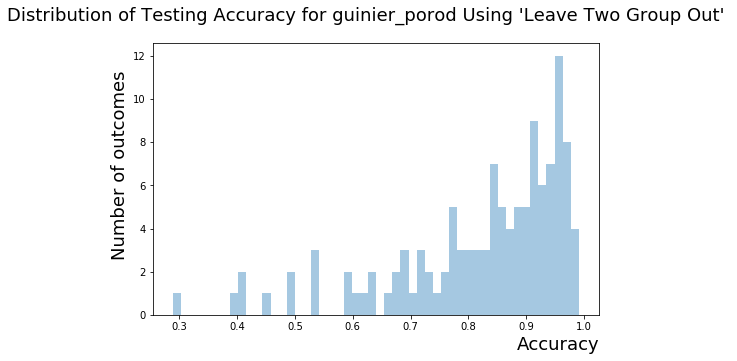

In [29]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for guinier_porod Using 'Leave Two Group Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [31]:
min(test_scores_by_ex)

0.28965517241379313

In [32]:
max(test_scores_by_ex)

0.9908675799086758

In [35]:
cv=LeavePGroupsOut(n_groups=2).split(data[features], data[['unidentified']], groups=data['experiment_id'])

scaler = preprocessing.StandardScaler()
scaler.fit(data[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters, cv=cv)
    
clf.fit(scaler.transform(data[features]), data['unidentified'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.1, 'l1_ratio': 0, 'penalty': 'l2'}
Training score:  0.983


In [45]:
test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = data[(data['experiment_id']!= experiments[i]) & (data['experiment_id']!= experiments[j])]
        test = data[(train['experiment_id']== experiments[i]) | (data['experiment_id']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.1,loss= 'log', l1_ratio= 0, penalty= 'l2')

        log.fit(scaler.transform(tr[features]), tr['unidentified'])
        test_score = log.score(scaler.transform(test[features]), test['unidentified'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

Testing on:  R6 and R12
test score:  0.990314769976

Testing on:  R6 and Reaction_C
test score:  1.0

Testing on:  R6 and R2
test score:  1.0

Testing on:  R6 and R3
test score:  1.0

Testing on:  R6 and R1
test score:  0.9475

Testing on:  R6 and R5
test score:  1.0

Testing on:  R6 and R4
test score:  1.0

Testing on:  R6 and Reaction_D
test score:  0.994350282486

Testing on:  R6 and Reaction_G
test score:  1.0

Testing on:  R6 and Reaction_B
test score:  1.0

Testing on:  R6 and Reaction_A
test score:  1.0

Testing on:  R6 and R13
test score:  0.990476190476

Testing on:  R6 and Reaction_H
test score:  1.0

Testing on:  R6 and R7
test score:  1.0

Testing on:  R6 and Reaction_E
test score:  1.0

Testing on:  R12 and Reaction_C
test score:  0.989847715736

Testing on:  R12 and R2
test score:  0.990610328638

Testing on:  R12 and R3
test score:  0.991130820399

Testing on:  R12 and R1
test score:  0.943238731219

Testing on:  R12 and R5
test score:  0.9918200409

Testing on:  R12 and

Text(0,0.9,'Number of outcomes')

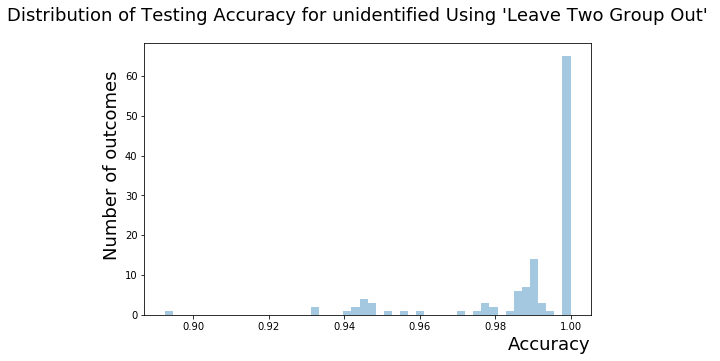

In [46]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for unidentified Using 'Leave Two Group Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [38]:
min(test_scores_by_ex)

0.88508557457212711

In [39]:
max(test_scores_by_ex)

1.0

In [40]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['spherical_normal']], groups=train_good['experiment_id'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['spherical_normal'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'l1_ratio': 0.85, 'penalty': 'elasticnet'}
Training score:  0.992


In [41]:
test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment_id']!= experiments[i]) & (train_good['experiment_id']!= experiments[j])]
        test = train_good[(train['experiment_id']== experiments[i]) | (train_good['experiment_id']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0.85, penalty= 'elasticnet')

        log.fit(scaler.transform(tr[features]), tr['spherical_normal'])
        test_score = log.score(scaler.transform(test[features]), test['spherical_normal'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

Testing on:  R6 and R12
test score:  0.996894409938

Testing on:  R6 and Reaction_C
test score:  1.0

Testing on:  R6 and R2
test score:  0.995515695067

Testing on:  R6 and R3
test score:  0.951612903226

Testing on:  R6 and R1
test score:  1.0

Testing on:  R6 and R5
test score:  0.996503496503

Testing on:  R6 and R4
test score:  1.0

Testing on:  R6 and Reaction_D
test score:  0.994219653179

Testing on:  R6 and Reaction_G
test score:  1.0

Testing on:  R6 and Reaction_B
test score:  0.993975903614

Testing on:  R6 and Reaction_A
test score:  1.0

Testing on:  R6 and R13
test score:  0.994444444444

Testing on:  R6 and Reaction_H
test score:  0.993975903614

Testing on:  R6 and R7
test score:  0.989071038251

Testing on:  R6 and Reaction_E
test score:  1.0

Testing on:  R12 and Reaction_C
test score:  1.0

Testing on:  R12 and R2
test score:  0.994100294985

Testing on:  R12 and R3
test score:  0.950549450549

Testing on:  R12 and R1
test score:  0.997907949791

Testing on:  R12 an

Text(0,0.9,'Number of outcomes')

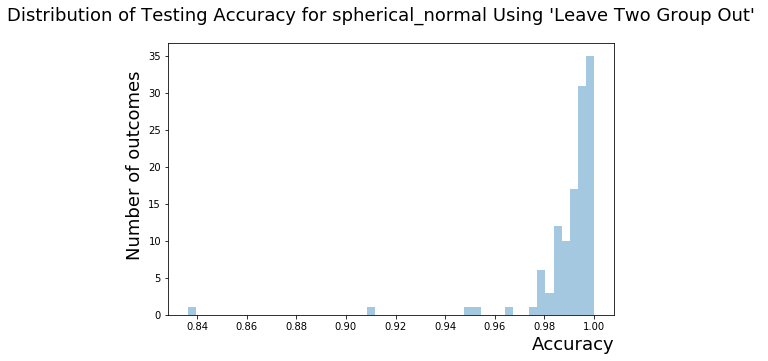

In [42]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for spherical_normal Using 'Leave Two Group Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [43]:
min(test_scores_by_ex)

0.83653846153846156

In [44]:
max(test_scores_by_ex)

1.0

In [47]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['diffraction_peaks']], groups=train_good['experiment_id'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['diffraction_peaks'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 1.0, 'penalty': 'l1'}
Training score:  0.979


In [48]:
test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment_id']!= experiments[i]) & (train_good['experiment_id']!= experiments[j])]
        test = train_good[(train['experiment_id']== experiments[i]) | (train_good['experiment_id']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.0001,loss= 'log', l1_ratio= 1.0, penalty= 'l1')

        log.fit(scaler.transform(tr[features]), tr['diffraction_peaks'])
        test_score = log.score(scaler.transform(test[features]), test['diffraction_peaks'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

Testing on:  R6 and R12
test score:  0.965838509317

Testing on:  R6 and Reaction_C
test score:  0.989528795812

Testing on:  R6 and R2
test score:  0.986547085202

Testing on:  R6 and R3
test score:  0.987903225806

Testing on:  R6 and R1
test score:  0.977900552486

Testing on:  R6 and R5
test score:  0.972027972028

Testing on:  R6 and R4
test score:  0.991304347826

Testing on:  R6 and Reaction_D
test score:  0.994219653179

Testing on:  R6 and Reaction_G
test score:  0.993506493506

Testing on:  R6 and Reaction_B
test score:  0.981927710843

Testing on:  R6 and Reaction_A
test score:  0.988826815642

Testing on:  R6 and R13
test score:  0.988888888889

Testing on:  R6 and Reaction_H
test score:  0.993975903614

Testing on:  R6 and R7
test score:  0.983606557377

Testing on:  R6 and Reaction_E
test score:  0.990291262136

Testing on:  R12 and Reaction_C
test score:  0.960912052117

Testing on:  R12 and R2
test score:  0.970501474926

Testing on:  R12 and R3
test score:  0.975274725

Text(0,0.9,'Number of outcomes')

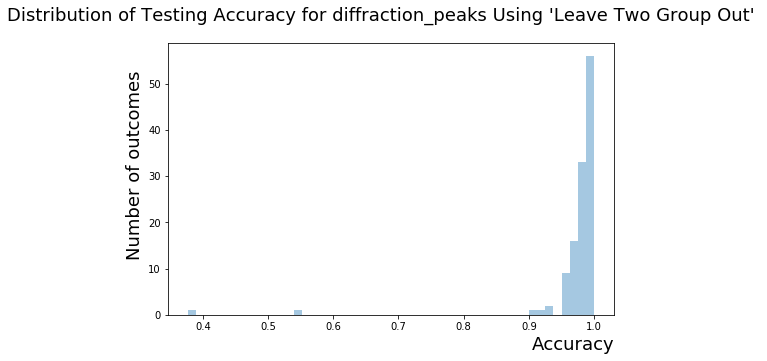

In [49]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for diffraction_peaks Using 'Leave Two Group Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [50]:
max(test_scores_by_ex)

1.0

In [51]:
min(test_scores_by_ex)

0.37752161383285304

#### Step 3. Train and Save Regression models

The approach is the same as above, but for a different set of models. These are the three regression models for the scattering spectrum parameters affecting curve shape. In the current version, the regression model output is one-dimensional, so these are mostly useful for spectra containing **one** 'guinier_porod' and/or **one** 'spherical_normal' scatterer population.

In [9]:
t0 = time()
scalers, models, accuracy = train_regressors(data, hyper_parameters_search = True, model= 'all')
print("Training took about {:.2f} minutes".format((time()-t0)/60))

save_models(scalers, models, accuracy, regressors_path)

Training took about 15.67 minutes


In [10]:
print('-----trained model accuracies-----')
for model_name, acc in accuracy.items():
    print('{}: {:.4f}'.format(model_name,acc))

-----trained model accuracies-----
r0_sphere: 0.2921
sigma_sphere: 0.6119
rg_gp: 0.2768


In [ ]:
test_results2 = [] # dataframes
r0_sphere_scores = []
sigma_sphere_scores = []
rg_gp_scores = []

for d in experiments:
    train = data[data['experiment_id']!= d]
    test = data[data['experiment_id']== d]
    scalers, models, accuracy = train_classifiers(train, hyper_parameters_search = True, model='all')
    
    s1 = preprocessing.StandardScaler()
    set_param(s1,scalers['r0_sphere'])
    transf1 = s1.transform(test[features])
    m1 = linear_model.SGDClassifier()
    set_param(m1,models['r0_sphere'])
    test.r0_sphere_predicted = m1.predict(transf1)
    test_score_r0_sphere = m1.score(transf1, test['r0_sphere'])
    r0_sphere_scores.append(test_score_r0_sphere)
    
    s2 = preprocessing.StandardScaler()
    set_param(s2,scalers['sigma_sphere'])
    transf2 = s2.transform(test[features])
    m2 = linear_model.SGDClassifier()
    set_param(m2,models['sigma_sphere'])
    test.sigma_sphere_predicted = m2.predict(transf2)
    test_score_sigma_sphere = m2.score(transf2, test['sigma_sphere'])
    sigma_sphere_scores.append(test_score_sigma_sphere)
    
    s3 = preprocessing.StandardScaler()
    set_param(s3,scalers['rg_gp'])
    transf3 = s3.transform(test[features])
    m3 = linear_model.SGDClassifier()
    set_param(m3,models['rg_gp'])
    test.rg_gp_predicted = m3.predict(transf1)
    test_score_rg_gp = m3.score(transf3, test['rg_gp'])
    rg_gp_scores.append(test_score_rg_gp)
    
    test_results2.append(test)